<a href="https://colab.research.google.com/github/onuda22/skripsi-apple-diseases/blob/main/Transformasi_dan_Build_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Koneksikan colab dengan drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Import Library

*Import Library* yang dibutuhkan untuk proses transformasi data dan  pembangunan model

In [ ]:
import os
import shutil
import random
import cv2
import time

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from sklearn.metrics import confusion_matrix

#Transformasi Data

In [ ]:
#Panggil folder dataset dengan memasukkannya ke dalam variabel path_dir
path_dir = '/content/drive/MyDrive/Coding/Skripsi/Dataset/skenario_data_A'

In [ ]:
#Melihat jumlah isi data dalam setiap kelas pada dataset yang digunakan untuk tahap training
names = []
nums = []
data = {'Nama Kelas':[], 'Jumlah Sample':[]}

for i in os.listdir(path_dir+'/train'):
  nums.append(len(os.listdir(path_dir+'/train/'+i)))
  names.append(i)

data['Nama Kelas']+=names
data['Jumlah Sample']+=nums

df = pd.DataFrame(data)
df

In [ ]:
#Memvisualisasikan jumlah data dari setiap kelas
sns.barplot(x=df['Nama Kelas'],y=df['Jumlah Sample'])

In [ ]:
### Melihat contoh isi dari setiap data kelas secara acak

#Mendefinisikan nama tiap kelas dalam folder train
classes = os.listdir(path_dir+'/train')

#Melakukan ploting gambar dengan ukuran setiap gambar adalah 30x30 piksel
#Jumlah gambar yang akan ditampilkan secara acak ada 10 gambar
plt.figure(figsize=(30,30))
for x in range(10):

  #Plotting dibuat menjadi 2 baris gambar dengan setiap baris terdiri dari 5 gambar
  i = random.randint(0,2)
  images = os.listdir(path_dir+'/train'+'/'+classes[i])

  #Dipilih data secara acak dari data ke-1 s.d. data ke-100
  j = random.randint(0,100)
  image = cv2.imread(path_dir+'/train'+'/'+classes[i]+'/'+images[j])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  ax = plt.subplot(5, 5, x + 1)

  #Menampilkan gambar
  plt.imshow(image)
  #Menamai setiap data sesuai kelasnya masing-masing
  plt.title(classes[i])
  #informasi sumbu-x dimatikan karena tidak diperlukan
  plt.axis("off")

#menampilkan gambar yang diperoleh
plt.show()

In [ ]:
#Lakukan transformasi dan Augmentasi pada data training agar persebaran menjadi lebih banyak
data_generator = ImageDataGenerator(
    rescale=1./255,  # Normalisasi skala gambar
    rotation_range=180,  # Rotasi dalam rentang 180 derajat
    width_shift_range=0.2,  # Pergeseran horisontal sebesar 20% dari lebar gambar
    height_shift_range=0.2,  # Pergeseran vertikal sebesar 20% dari tinggi gambar
    zoom_range=[0.2, 1.8],  # Zoom antara 20% hingga 180%
    shear_range=0.2,  # Rotasi persegi panjang sebesar 20 derajat
    horizontal_flip=True,  # Membalikkan gambar secara horizontal
    vertical_flip=True,  # Membalikkan gambar secara vertikal
    brightness_range=[0.2, 1.8],  # Rentang perubahan kecerahan antara 20% hingga 120%
    fill_mode='nearest'  # Pengisian piksel yang hilang dengan piksel terdekat
)

#Untuk data validasi hanya mengubah normalisasinya saja. Karena data validasi hanya digunakan untuk memvalidasi model
dataval_generator = ImageDataGenerator(
    rescale=1./255
)

In [ ]:
#inisiasi data dan ubah ukurannya lalu masukkan ke dalam variabel
train_datagen = data_generator.flow_from_directory(
    path_dir+'/train',
    target_size=(224, 224),
    batch_size=32, #setiap satu kali pelatihan data yang digunakan sebanyak 32 data secara acak
    class_mode='categorical'
)

val_datagen = dataval_generator.flow_from_directory(
    path_dir+'/val',
    target_size=(224, 224),
    class_mode='categorical'
)

Found 576 images belonging to 3 classes.
Found 81 images belonging to 3 classes.


#Build Model

Skenario Parameter Tuning

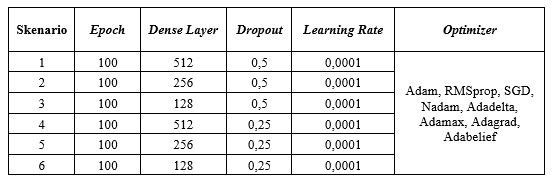

In [ ]:
#memanggil pre-trained model mobileNet tanpa layer teratas (klasifikasi)
mobilenet = tf.keras.applications.mobilenet.MobileNet(input_shape=(224,224,3),
                                                      include_top=False,
                                                      weights='imagenet')
#hidden layer dari pre-trained model dibekukan agar pengetahuan dari pelatihan sebelumnya tidak terganggu
mobilenet.trainable = False

#membuat layer teratas untuk tugas klasifikasi daun apel
#konfigurasi disesuaikan dengan skenario parameter tuning
model = Sequential([
    mobilenet,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(512, activation="relu"), #Disini dense layer yang sedang digunakan adalah 512
    Dropout(0.5), #Dropout yang sedang digunakan adalah 0,5
    Dense(3, activation="softmax", name="classification")
])

In [ ]:
#Definisikan variabel untuk menampung path model yang akan dibuat (sekaligus memberi nama model dengan diakhiri .hdf5)
fname="/content/drive/MyDrive/Coding/Skripsi/Model/Model_A_0,5_128/Model/Model.A3.05.128_SGD.hdf5"

#Checkpoint digunakan untuk memonitor grafik val_accuracy, saat val_accuracy lebih tinggi dari val_accuracy sebelumnya
#- model akan disimpan ke dalam path "fname" dengan metode callbacks
#- jika tidak, model tidak akan disimpan sampai kondisi awal terpenuhi
checkpoint = ModelCheckpoint(fname, monitor="val_accuracy", mode="max", save_best_only=True, verbose=1)

#definisikan variabel log_file untuk menampung path rekaman model yang akan dibuat (sekaligus memberi nama model berekstensi CSV)
#metode ini akan merekam seluruh nilai selama pelatihan
log_file = '/content/drive/MyDrive/Coding/Skripsi/Model/Model_A_0,5_128/Training Log/training_log_A3_0,5_128_SGD.csv'
csv_logger = CSVLogger(log_file)
callbacks = [checkpoint, csv_logger]

In [ ]:
#Memanggil optimizer yang akan digunakan (Disesuaikan dengan skenario parameter tuning)
#Mendefinisikan learning_rate yaitu 0,0001
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=SGD(learning_rate=(0.0001)),
              loss='categorical_crossentropy',
              metrics=['accuracy',tf.keras.metrics.AUC()]) #Metriks yang diukur akurasi dan AUC
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 128)               131200    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 classification (Dense)      (None, 3)                 3



---


Khusus untuk Optimizer Adabelief harus menggunakan addons. Karena keras tidak menyediakan optimizer tersebut



In [ ]:
#install addons
!pip install tensorflow-addons

In [ ]:
#Import addons
import tensorflow_addons as tfa

In [ ]:
#Import optimizer Adabelief dari tensorflow-addons
optimizer=tfa.optimizers.AdaBelief(learning_rate=0.0001, epsilon=1e-16, rectify=True)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy',tf.keras.metrics.AUC()])
model.summary()

---

In [ ]:
start_time = time.time() #digunakan untuk menghitung lama waktu pelatihan
history = model.fit(train_datagen,
                    validation_data=val_datagen,
                    epochs=100,
                    callbacks=callbacks,
                    verbose=1)
end_time = time.time() #digunakan untuk menghitung lama waktu pelatihan

In [ ]:
#menghitung lama waktu pelatihan
training_time = end_time - start_time

m, s = divmod(training_time, 60)
h, m = divmod(m, 60)
training_time_format = "%d:%02d:%02d" % (h, m, s)

print("Waktu Pelatihan: %s" % training_time_format)

Waktu Pelatihan: 0:25:13


#Evaluasi Model

In [ ]:
#Memvisualisasikan grafik Akurasi dan Loss dari model yang dibuat
model.evaluate(val_datagen)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'],loc='upper right')
plt.show()
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'],loc='upper right')
plt.show()

#Testing Model dengan Confusion Matrix

In [ ]:
# Mendefinisikan path ke direktori gambar pengujian
test_dir = "/content/drive/MyDrive/Coding/Skripsi/Dataset/skenario_data_A/test"

# Membuat objek ImageDataGenerator untuk normalisasi data
test_datagen = ImageDataGenerator(rescale=1./255)

# Membuat generator data pengujian
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # Ukuran gambar target
    batch_size=32,
    class_mode='categorical',  # Mode kelas berdasarkan direktori
    shuffle=False  # Jangan mengacak urutan data
)


In [ ]:
# Mendapatkan prediksi kelas dari model untuk data pengujian
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Mendapatkan label yang sebenarnya untuk data pengujian
y_true = test_generator.classes

# Menghitung matriks kebingungan
cm = confusion_matrix(y_true, y_pred_classes)

# Mendefinisikan label kelas
class_labels = test_generator.class_indices

# Membuat heatmap dari matriks kebingungan
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# Menyesuaikan tampilan plot
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Menampilkan plot
plt.show()
